# Price stock tendency prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import mlflow
import mlflow.sklearn
from tqdm.notebook import trange, tqdm

from DataHelper import *

# increase plot size
plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
DATA_PATH = './data'
QUOTATION = 'IBM'
FILE_SUFFIX = '.txt'

In [3]:
PREDICT_N = 1

In [4]:
price_column='Close'
df, feature_names = features_pipeline(f"{DATA_PATH}/{QUOTATION}{FILE_SUFFIX}", predict_n=PREDICT_N,
    price_column=price_column, normalize_features=True)

df.head()

,Date,Open,High,Low,Close,Adjusted,Volume,Difference,PercentageDiff,Tendency,...,MACD,MACD_diff,MACD_signal,BodyLen,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
33,1962-03-21,7.340000,7.360000,7.320000,7.346667,1.790263,262500,0.135913,0.101597,higher,...,0.238808,0.081335,0.217010,-0.963745,-0.979647,-0.977760,-1.0,-1.0,-0.365719,-0.375660
34,1962-03-22,7.320000,7.320000,7.266667,7.266667,1.770770,240000,0.142241,0.181428,lower,...,0.236837,0.078876,0.215737,-0.979625,-0.980493,-0.977844,-1.0,-1.0,-0.411013,-0.542235
35,1962-03-23,7.273333,7.306667,7.273333,7.293333,1.777267,187500,0.151406,0.306465,higher,...,0.235802,0.079002,0.214478,-0.995206,-0.981188,-0.977961,-1.0,-1.0,-0.397312,-0.498637
36,1962-03-26,7.293333,7.320000,7.280000,7.290000,1.776455,135000,0.143551,0.198036,lower,...,0.234497,0.078498,0.213167,-0.983221,-0.981983,-0.978002,-1.0,-1.0,-0.409768,-0.651225
37,1962-03-27,7.273333,7.273333,7.146667,7.153333,1.743153,352500,0.157079,0.386197,lower,...,0.234743,0.081565,0.212175,-0.979626,-0.982415,-0.978371,-1.0,-1.0,-0.294152,-0.455555


### Plots

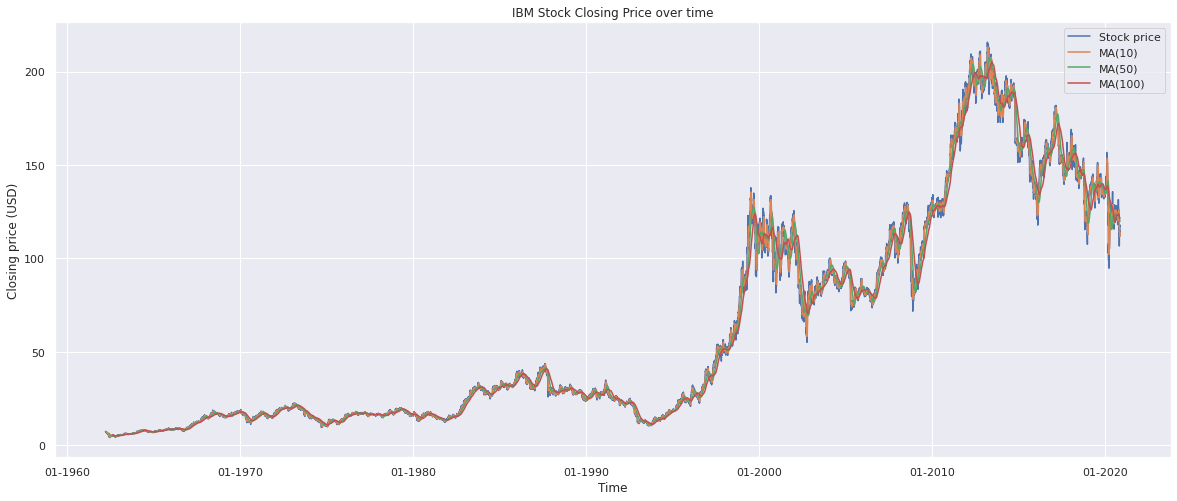

In [5]:
import datetime
import matplotlib.dates as mdates

N_YEARS = 50
values = df.tail(365*N_YEARS)[price_column]

x_values = [datetime.datetime.strptime(d,"%Y-%m-%d").date() for d in df.tail(365*N_YEARS).Date]
ax = plt.gca()
ax.set(title=f"{QUOTATION} Stock Closing Price over time", ylabel='Closing price (USD)', xlabel='Time')

formatter = mdates.DateFormatter("%m-%Y")

ax.xaxis.set_major_formatter(formatter)

MAs = [10, 50, 100]

plt.plot(x_values, values, label="Stock price")

for val in MAs:
    plt.plot(x_values, values.rolling(val).mean(), label=f"MA({val})")

plt.legend(loc='best')

### Plot histogram differences

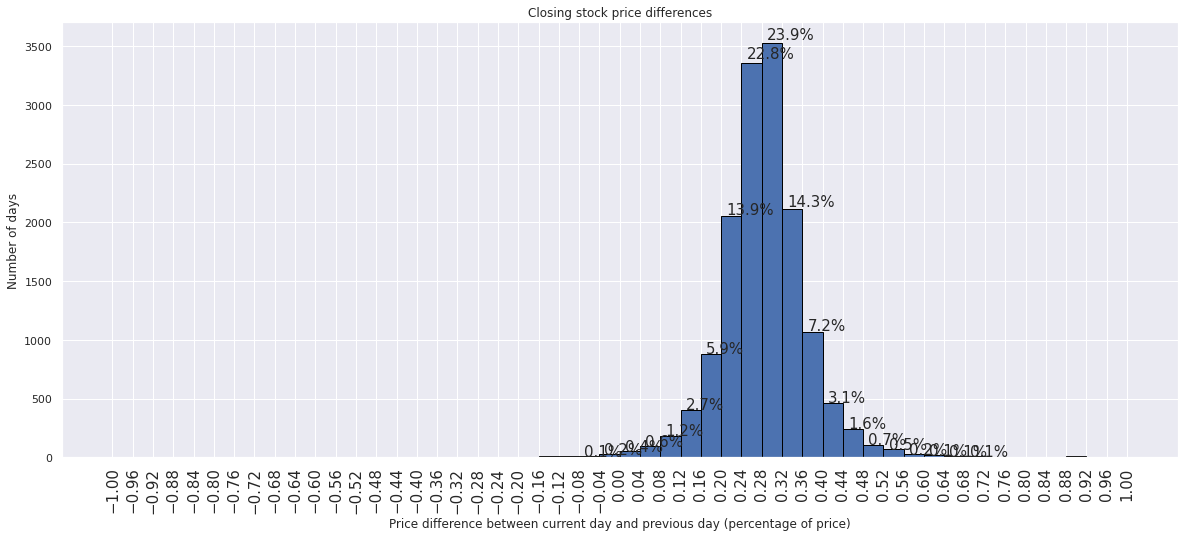

In [6]:
import matplotlib.ticker as mtick

def label_density_hist(ax, n, bins, x=4, y=0.01, r=0, **kwargs):
    """
    adapted from https://stackoverflow.com/questions/6352740/matplotlib-label-each-bin
    """
    
    total = sum(n)

    # plot the label/text to each bin
    for i in range(0, len(n)):
        x_pos = (bins[i + 1] - bins[i]) / x + bins[i]
        y_pos = n[i] + (n[i] * y)
        
        if n[i] < 10:
            continue
        
        label = f"{(n[i] * 100.0 / total):.1f}%"
        ax.text(x_pos, y_pos, label, kwargs)
        
values = df['PercentageDiff']
ax = plt.gca()

counts, bins, patches = ax.hist(values, 50, histtype='bar', ec='black')
plt.xticks(bins, fontsize=15, rotation=90)
plt.title("Closing stock price differences")
plt.xlabel('Price difference between current day and previous day (percentage of price)')
plt.ylabel('Number of days')
label_density_hist(ax, counts, bins, fontsize=15)
plt.show()

### ML Data preparation

In [7]:
df.head()

,Date,Open,High,Low,Close,Adjusted,Volume,Difference,PercentageDiff,Tendency,...,MACD,MACD_diff,MACD_signal,BodyLen,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
33,1962-03-21,7.340000,7.360000,7.320000,7.346667,1.790263,262500,0.135913,0.101597,higher,...,0.238808,0.081335,0.217010,-0.963745,-0.979647,-0.977760,-1.0,-1.0,-0.365719,-0.375660
34,1962-03-22,7.320000,7.320000,7.266667,7.266667,1.770770,240000,0.142241,0.181428,lower,...,0.236837,0.078876,0.215737,-0.979625,-0.980493,-0.977844,-1.0,-1.0,-0.411013,-0.542235
35,1962-03-23,7.273333,7.306667,7.273333,7.293333,1.777267,187500,0.151406,0.306465,higher,...,0.235802,0.079002,0.214478,-0.995206,-0.981188,-0.977961,-1.0,-1.0,-0.397312,-0.498637
36,1962-03-26,7.293333,7.320000,7.280000,7.290000,1.776455,135000,0.143551,0.198036,lower,...,0.234497,0.078498,0.213167,-0.983221,-0.981983,-0.978002,-1.0,-1.0,-0.409768,-0.651225
37,1962-03-27,7.273333,7.273333,7.146667,7.153333,1.743153,352500,0.157079,0.386197,lower,...,0.234743,0.081565,0.212175,-0.979626,-0.982415,-0.978371,-1.0,-1.0,-0.294152,-0.455555


In [8]:
print(feature_names)

['Difference', 'PercentageDiff', 'Tendency', 'SMA(10)', 'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'LowLen', 'RSI(14)', 'GAP', 'RSI_Diff', 'Volume_diff', 'Next', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc']


In [9]:
dataset = df.copy()

#feature_names = ['MACD_signal', 'MACD_diff', 'SMA(10)', 'SMA(20)', 'BG_L_Band', 'BG_H_Band', 'EMA(14)', 'MACD']  + ['Next']

dataset = df.loc[:, feature_names]
#df = df.drop(columns=['Tendency', 'Date', 'Difference'])
for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':1, 'stay':0, 'lower':-1})

dataset.head()

,Difference,PercentageDiff,Tendency,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),LowLen,RSI(14),...,MACD,MACD_diff,MACD_signal,BodyLen,BG_L_Band,BG_H_Band,BG_L_Band_Indicator,BG_H_Band_Indicator,ROC,StochOsc
33,0.135913,0.101597,1,-0.980276,-0.979046,-0.980803,0.207671,-0.181677,-1.000000,-0.427272,...,0.238808,0.081335,0.217010,-0.963745,-0.979647,-0.977760,-1.0,-1.0,-0.365719,-0.375660
34,0.142241,0.181428,-1,-0.981061,-0.979508,-0.981409,0.205143,-0.178637,-0.996633,-0.484954,...,0.236837,0.078876,0.215737,-0.979625,-0.980493,-0.977844,-1.0,-1.0,-0.411013,-0.542235
35,0.151406,0.306465,1,-0.981655,-0.979912,-0.981899,0.209026,-0.176848,-0.993266,-0.449694,...,0.235802,0.079002,0.214478,-0.995206,-0.981188,-0.977961,-1.0,-1.0,-0.397312,-0.498637
36,0.143551,0.198036,-1,-0.982159,-0.980325,-0.982444,0.207185,-0.175984,-0.993266,-0.498518,...,0.234497,0.078498,0.213167,-0.983221,-0.981983,-0.978002,-1.0,-1.0,-0.409768,-0.651225
37,0.157079,0.386197,-1,-0.982153,-0.980732,-0.982771,0.214555,-0.179829,-0.973906,-0.348670,...,0.234743,0.081565,0.212175,-0.979626,-0.982415,-0.978371,-1.0,-1.0,-0.294152,-0.455555


### Dataset class balance

<AxesSubplot:>

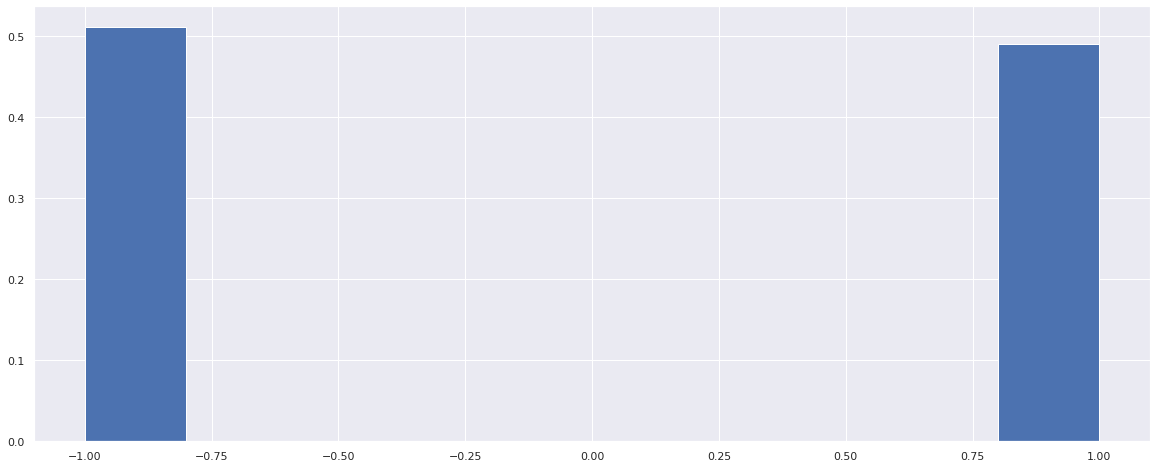

In [10]:
# plot normalized histogram
dataset['Next'].hist(weights = np.ones_like(dataset.Next) / len(dataset.Next))

### Train / Test data 

In [11]:
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']

In [12]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.7

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=TRAIN_RATIO, random_state=42)

print(f"Train size : {len(X_train)}, test size : {len(X_test)} ({(1-TRAIN_RATIO)*100:.0f}%)")

Train size : 10334, test size : 4430 (30%)


## Classifier and evaluation

In [13]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(Y), Y)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(Y), class_weights)}

    print(class_weights)
else:
    class_weights = None

{-1: 0.9790450928381963, 1: 1.0218715393133997}


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[-1  1], y=33      -1
34       1
35      -1
36      -1
37       1
        ..
14792   -1
14793    1
14794    1
14795   -1
14796   -1
Name: Next, Length: 14764, dtype: int64 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = False

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 1, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 500}, 'SVM': {'gamma': 'auto'}, 'LR': {'penalty': 'l2', 'C': 1.0}}
param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        'C':[1.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], n_jobs=4)

    
    clf.fit(X_train, Y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], n_jobs=8)
    clf.fit(X_train, Y_train)
    best_params['RandomForest'] = clf.best_params_

    
    """svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], n_jobs=4, verbose=30)
    clf.fit(X_train, Y_train)
    best_params['SVM'] = clf.best_params_"""
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], n_jobs=4)
    clf.fit(X_train, Y_train)


    print(best_params)

### Classifiers

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [23]:
print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, Y_train)
    
print("Training done.")

Training...
Training done.


c:\users\ludo\documents\school\master_thesis\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[DTree] Accuracy : 0.52, F1 : 0.56
[RandomForest] Accuracy : 0.53, F1 : 0.53
[SVM] Accuracy : 0.52, F1 : 0.54
[LR] Accuracy : 0.53, F1 : 0.53


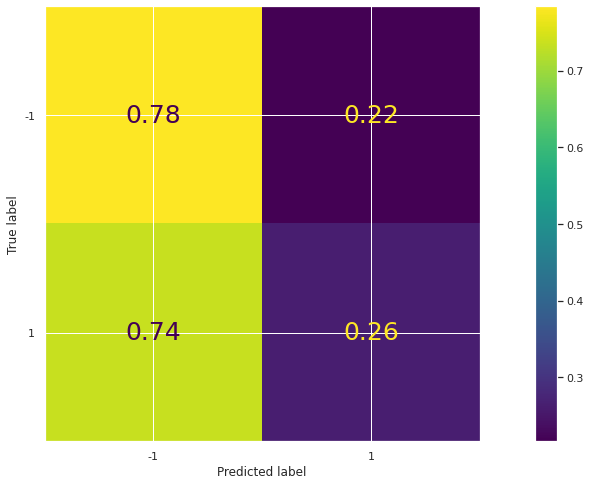

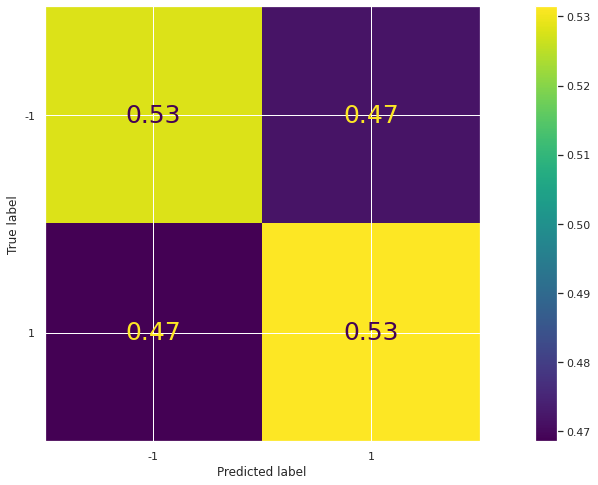

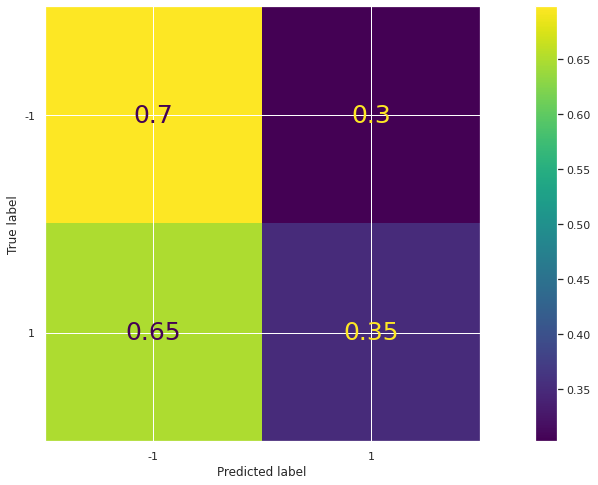

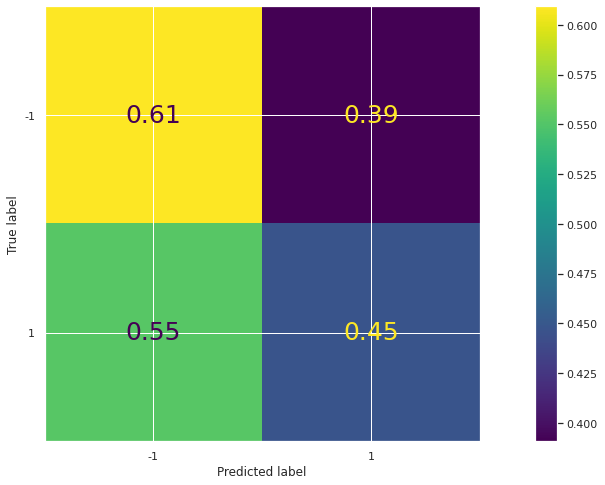

In [24]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

for clf_label, clf in clf_dict.items():
    with mlflow.start_run(run_name=clf_label):
        Y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(Y_pred, Y_test)
        f1 = f1_score(Y_pred, Y_test, average='weighted')
        


        for param, val in best_params[clf_label].items():
            mlflow.log_param(param, val)
        mlflow.log_metric('acc', accuracy)
        mlflow.log_metric('f1', f1)
        mlflow.sklearn.log_model(clf, "sklearn model")
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, Y_test, normalize='true')

|--- MACD_diff <= 0.06
|   |--- class: 1
|--- MACD_diff >  0.06
|   |--- class: -1



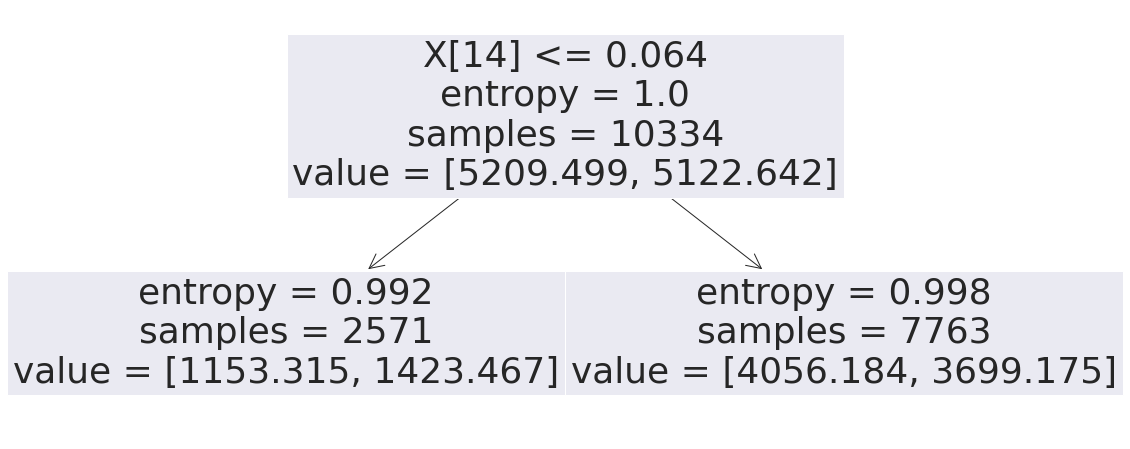

In [18]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(list(X_train.columns)))

print(rules)

In [19]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from numpy import mean, std


#feature_names = ['Volume', 'Volume_diff', 'PercentageDiff', 'Next']
dataset = df.copy()
dataset = df.loc[:, feature_names]
print(dataset.head())
X = dataset.loc[:, dataset.columns != 'Next']
Y = dataset['Next']


model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, Y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

    Difference  PercentageDiff Tendency   SMA(10)   SMA(20)   EMA(14)  \
33    0.135913        0.101597   higher -0.980276 -0.979046 -0.980803   
34    0.142241        0.181428    lower -0.981061 -0.979508 -0.981409   
35    0.151406        0.306465   higher -0.981655 -0.979912 -0.981899   
36    0.143551        0.198036    lower -0.982159 -0.980325 -0.982444   
37    0.157079        0.386197    lower -0.982153 -0.980732 -0.982771   

    EMA_Diff  SMA(20) - SMA(10)    LowLen   RSI(14)  ...      MACD  MACD_diff  \
33  0.207671          -0.181677 -1.000000 -0.427272  ...  0.238808   0.081335   
34  0.205143          -0.178637 -0.996633 -0.484954  ...  0.236837   0.078876   
35  0.209026          -0.176848 -0.993266 -0.449694  ...  0.235802   0.079002   
36  0.207185          -0.175984 -0.993266 -0.498518  ...  0.234497   0.078498   
37  0.214555          -0.179829 -0.973906 -0.348670  ...  0.234743   0.081565   

    MACD_signal   BodyLen  BG_L_Band  BG_H_Band  BG_L_Band_Indicator  \
33

In [20]:
from sklearn.feature_selection import VarianceThreshold

sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = sel.fit_transform(X)

print(X.shape)
print(selected.shape)

ValueError: could not convert string to float: 'higher'